# Imports

In [25]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
from os import makedirs, path, listdir, remove
import httplib2
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
import geopandas as gpd
from shutil import rmtree
import matplotlib.pyplot as plt

# Set variables

In [2]:
species = "NO2"
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"

In [5]:
# Data path
folder = path.abspath("tmp") # Choose a name for the data folder 
if not path.exists(folder):
    makedirs(folder)

# Download data

In [6]:
# Get LAQN site codes
url_sites = f"http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName={region}/Json"
               
london_sites = requests.get(url_sites)
sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
site_codes = sites_df["@SiteCode"].tolist()
print(len(site_codes))

250


In [7]:
# Download LAQN data

laqn_df = pd.DataFrame()

progress_bar = tqdm(site_codes)

for site_code in progress_bar:
    progress_bar.set_description(f'Working on site {site_code}')
    url_species = f"http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode={site_code}/SpeciesCode={species}/StartDate={start_date}/EndDate={end_date}/csv"
    cur_df = pd.read_csv(url_species)
    cur_df.columns = ["date", site_code]
    cur_df.set_index("date", drop=True, inplace=True)

#     try:
    if laqn_df.empty:
        laqn_df = cur_df.copy()
    else:
        laqn_df = laqn_df.join(cur_df.copy(), how="outer")

#     except ValueError:  # Trying to join with duplicate column names
#         rename_dict = {}
#         for x in list(set(cur_df.columns).intersection(laqn_df.columns)):
#             rename_dict.update({x: f"{x}_"})
#             print(f"Renamed duplicated column:\n{rename_dict}")
#         laqn_df.rename(mapper=rename_dict, axis="columns", inplace=True)
#         if laqn_df.empty:
#             laqn_df = cur_df.copy()
#         else:
#             laqn_df = laqn_df.join(cur_df.copy(), how="outer")
#         if verbose:
#             print(f"Joined.")

#     except KeyError:  # Trying to join along indexes that don't match
#         print(f"Troubleshooting {site_code}...")
#         cur_df.index = cur_df.index + ":00"
#         if laqn_df.empty:
#             laqn_df = cur_df.copy()
#         else:
#             laqn_df = laqn_df.join(cur_df.copy(), how="outer")
#         print(f"{site_code} joined.")

#     print("Data download complete. Removing sites with 0 data...")
laqn_df.dropna(axis="columns", how="all", inplace=True)
laqn_df.to_csv(path.join(folder, f"LAQN_{species}_{start_date}_{end_date}.csv"))

Working on site CE2: 100%|██████████| 250/250 [43:15<00:00, 10.38s/it] 


In [8]:
# Download LAQN metadata
request = requests.get("http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json")
london_sites_df = pd.DataFrame(request.json()['Sites']['Site'])
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"]!=""]
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"].astype(float)>51]

lat = london_sites_df["@Latitude"].values
lon = london_sites_df["@Longitude"].values

# Create a geopandas dataframe
london_sites_gdf = gpd.GeoDataFrame(london_sites_df, geometry=gpd.points_from_xy(lon, lat))
london_sites_gdf.to_file(path.join(folder, "LAQN_sites.shp"))

/tmp/ipykernel_604/364641893.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_sites_gdf.to_file(path.join(folder, "LAQN_sites.shp"))


In [10]:
# Download shape files for map plotting

# Get the web links for the borough & ward coordinate data files
web_address = "https://data.london.gov.uk/dataset/i-trees-canopy-ward-data"
status, response = httplib2.Http().request(web_address)
link_dict = {}

for link in BeautifulSoup(response, parse_only=SoupStrainer('a')):
    if link.has_attr('href') and link["href"].split(".")[-1]=="zip":
        link_dict[link['href'].split("/")[-1].split(".")[0]] = f"https://data.london.gov.uk/{link['href']}"
print(f"{len(link_dict)} links found")
        
# Download the borough & ward coordinate data files and unzip them
if not path.exists(path.join(folder, "i-Trees")):
    makedirs(path.join(folder, "i-Trees"))
print("Downloading shape data...")
for url in tqdm(link_dict.values()):
    request = requests.get(url)
    filepath = path.join(folder, "i-Trees", path.basename(url))
    file = open(filepath, 'wb')
    file.write(request.content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(path.join(folder, "i-Trees"))
    
# Compile a geopandas dataframe of the london wards coordinates
print("Compiling geopandas dataframe...")
london_wards_gdf = gpd.GeoDataFrame()

for borough in tqdm(link_dict.keys()):
    borough_folder = path.join(folder, "i-Trees", borough)
    shapefiles = [file for file in listdir(borough_folder) if file.split(".")[-1]=="shp"]
    for shapefile in shapefiles:
        gdf = gpd.read_file(path.join(borough_folder, shapefile))
        if london_wards_gdf.empty:
            london_wards_gdf = gdf
        else:
            london_wards_gdf = pd.concat([london_wards_gdf, gdf])

# Convert from ward level to boroughs
london_boroughs_gdf = london_wards_gdf.dissolve(by="BOROUGH")
london_boroughs_gdf.to_file(path.join(folder, "london_boroughs_coordinates.shp"))
rmtree(path.join(folder, "i-Trees"))

33 links found


100%|██████████| 33/33 [00:19<00:00,  1.70it/s]


Compiling geopandas dataframe...


100%|██████████| 33/33 [00:39<00:00,  1.21s/it]


# Load data

In [40]:
# Load LAQN data
laqn_df = pd.read_csv(path.join(folder, f"LAQN_{species}_{start_date}_{end_date}.csv"), index_col="date", infer_datetime_format=True)
print(laqn_df.shape)

(219169, 201)


(33, 10)


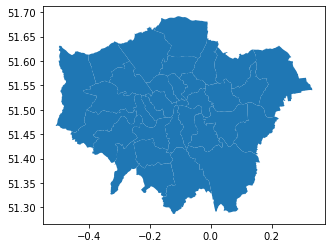

In [12]:
# Load map file
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

In [26]:
# Load LAQN metadata
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)

(247, 17)


# Plots

In [14]:
def plot_on_map(data_geodataframe, map_geodataframe, 
                data_column=None, map_column=None, 
                data_cmap=None, map_cmap=None, 
                data_color=None, map_color="whitesmoke", 
                data_markersize=0.1, 
                map_edge_color="black", 
                colorbar=False, 
                title="Greater London", 
                fontsize="25", 
                figsize=(20,10), 
                axis="off"):
    
    data_geodataframe.plot(column=data_column, 
                           ax=map_geodataframe.plot(column=map_column, 
                                                    figsize=figsize, 
                                                    color=map_color, 
                                                    edgecolor=map_edge_color, 
                                                    cmap=map_cmap), 
                           color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        colorbar_max = data_geodataframe[data_column].max()
        norm = plt.Normalize(data_geodataframe[data_column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=norm)).set_label(data_column)
    
    plt.suptitle(title, fontsize=fontsize)
    plt.axis(axis)
    plt.show()

## London sites

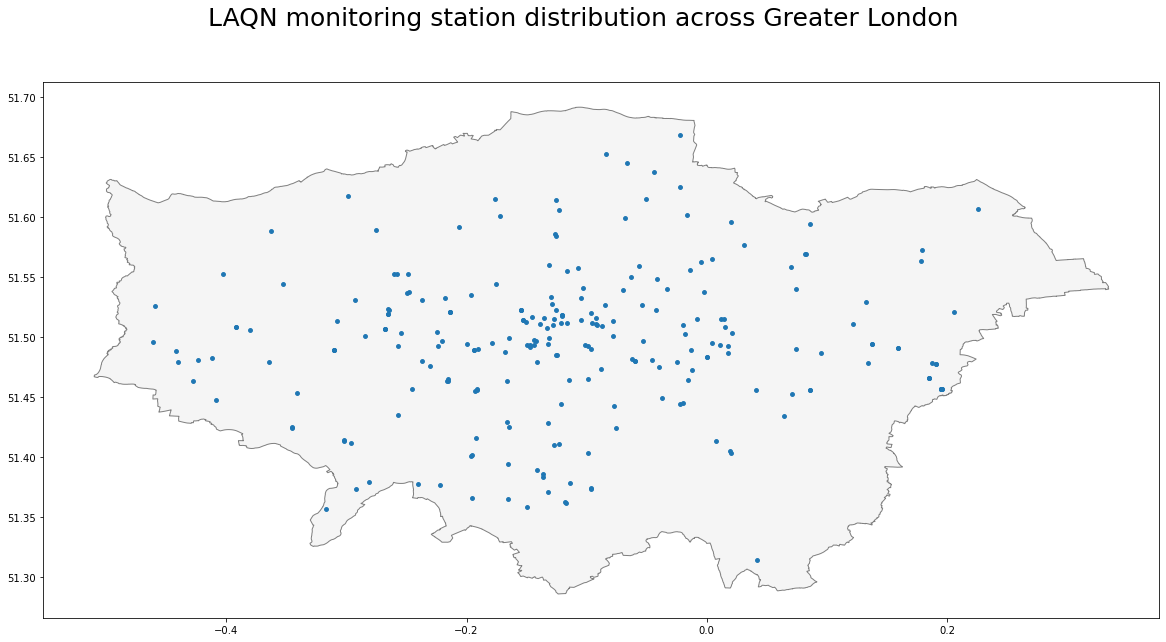

In [15]:
plot_on_map(london_sites_gdf, london_gdf, 
            title="LAQN monitoring station distribution across Greater London", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

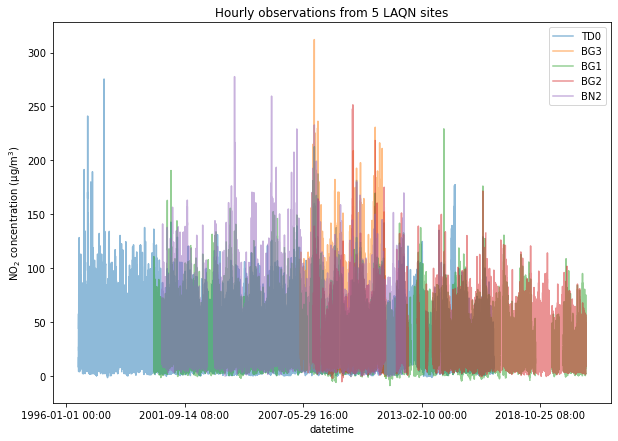

In [42]:
laqn_df[laqn_df.columns[0:5]].plot(alpha=0.5, figsize=(10,7))
plt.ylabel("NO$_2$ concentration (µg/m$^3$)")
plt.xlabel("datetime")
plt.title("Hourly observations from 5 LAQN sites")
plt.show()

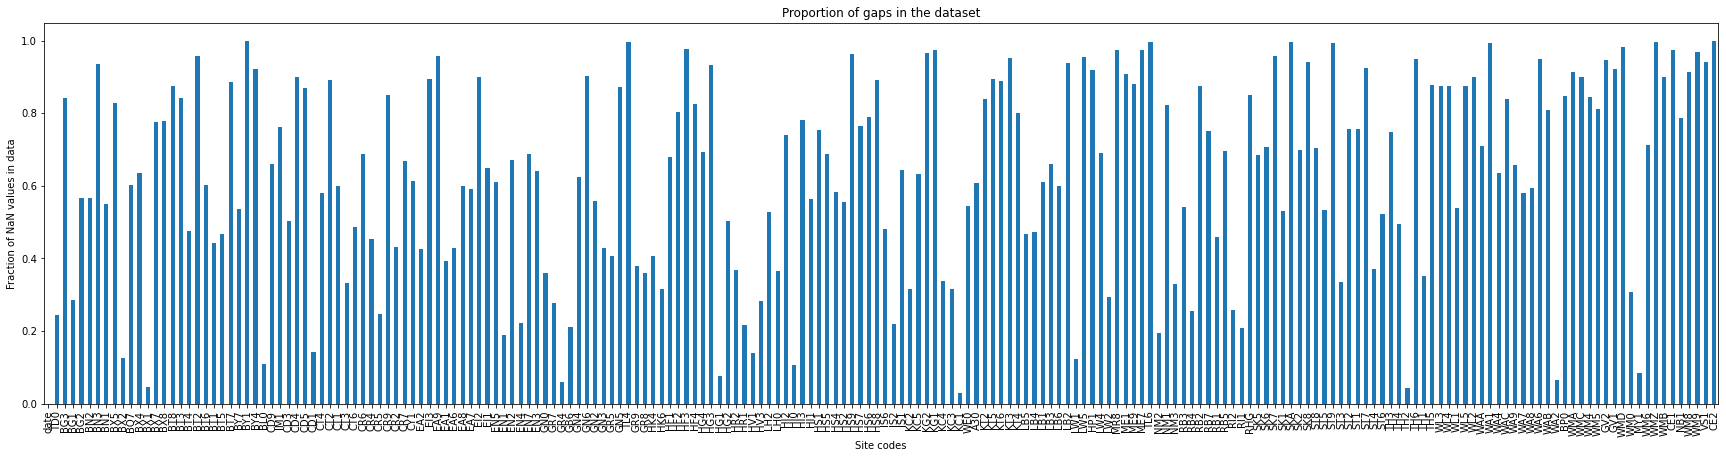

In [17]:
pd.DataFrame(laqn_df.isna().sum()/len(laqn_df)).plot.bar(figsize=(30,7), legend=False)
plt.ylabel("Fraction of NaN values in data")
plt.xlabel("Site codes")
plt.title("Proportion of gaps in the dataset")
plt.show()

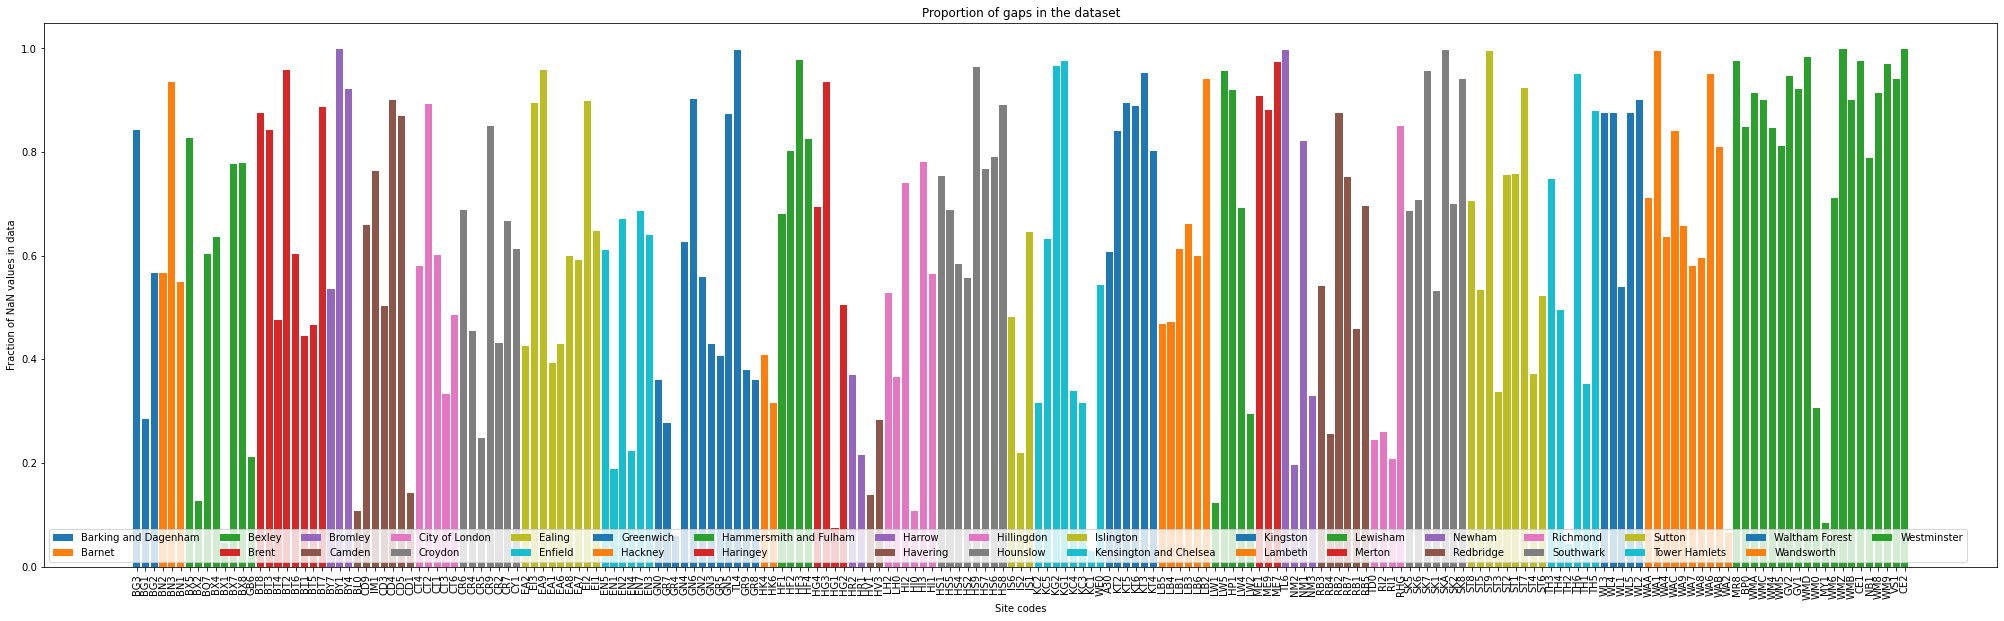

In [27]:
london_sites_gdf = pd.merge(london_sites_gdf, pd.DataFrame(laqn_df.isna().sum()/len(laqn_df), columns=["NaN fraction"]), left_on="@SiteCode", right_index=True)

fig, ax = plt.subplots(figsize=(35,10))

for borough in sorted(list(set(london_sites_gdf["@LocalAu_1"]))):
    gdf = london_sites_gdf.loc[london_sites_gdf["@LocalAu_1"]==borough]
    ax.bar(gdf["@SiteCode"], gdf["NaN fraction"], label=borough)
plt.xticks(rotation=90)
ax.legend(loc="lower left", ncol=int(np.round(len(set(london_sites_gdf["@LocalAu_1"]))/2))+1)
plt.ylabel("Fraction of NaN values in data")
plt.xlabel("Site codes")
plt.title("Proportion of gaps in the dataset")
plt.show()

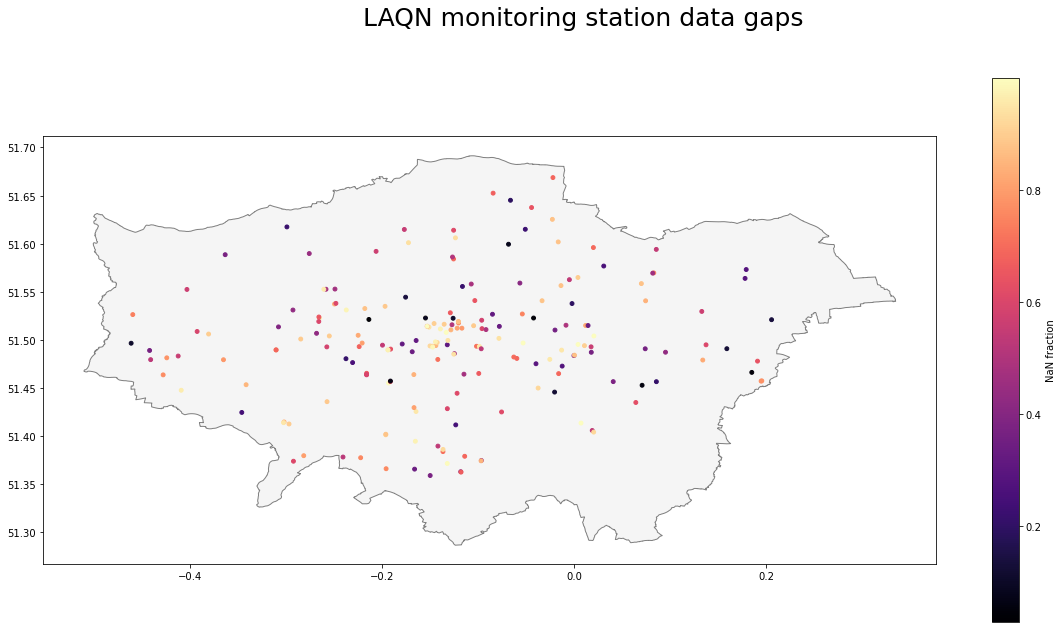

In [35]:
plot_on_map(london_sites_gdf, london_gdf, 
            data_column="NaN fraction", colorbar=True, data_cmap="magma", 
            title="LAQN monitoring station data gaps", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

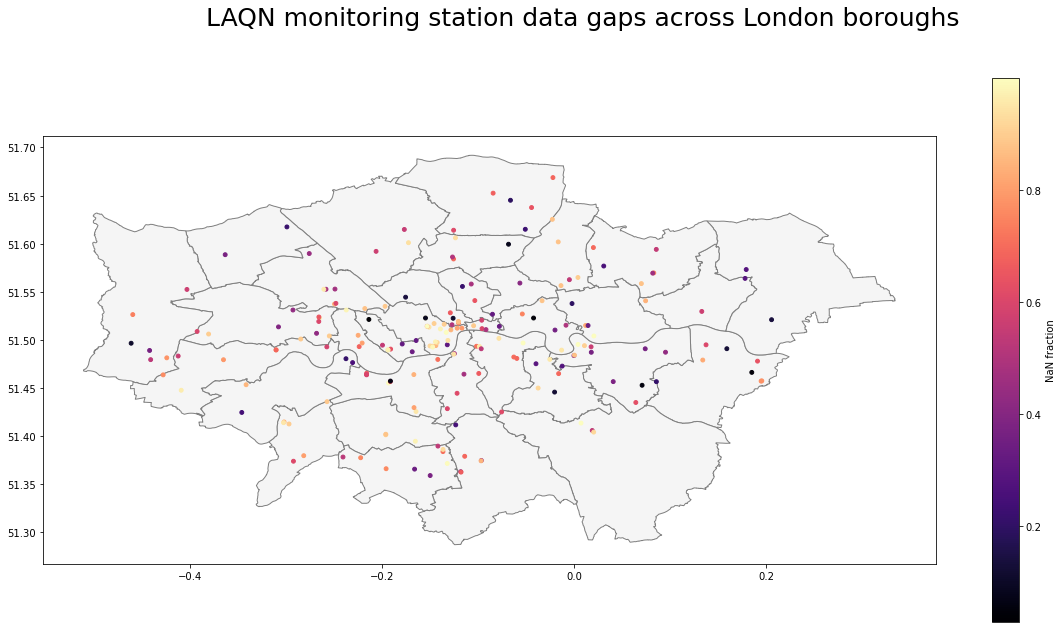

In [43]:
plot_on_map(london_sites_gdf, london_boroughs_gdf, 
            data_column="NaN fraction", colorbar=True, data_cmap="magma", 
            title="LAQN monitoring station data gaps across London boroughs", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")